In [24]:
%load_ext autoreload
%autoreload 2
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import os
from glob import glob
import h5py
from natsort import natsorted, ns

import ipywidgets as widgets
from IPython.display import display

from utils import classification_report, get_save_button, load_ground_truth_labels, mkdir_p

from sklearn.metrics import confusion_matrix

# Fixed paths
base_local = os.path.expanduser('~/Documents/Results')
base_rbr = os.path.expanduser('~/rbr_cnn/rtracker_caffe')

local_net_path = os.path.join(base_rbr,'net')
# local_data_path = os.path.join(base_rbr,'data_2stream')
# local_data_path = os.path.join(base_rbr,'data_balanced')
# local_data_path = os.path.join(base_rbr,'data')
local_data_path = os.path.join(base_rbr,'data', 'data_flow_norm_rep')

# SET this
in_archive = True
SSH_server = 'thor'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
if not in_archive:
    local_model_path = os.path.join(base_rbr,'models')
    local_log_path = os.path.join(base_rbr,'log')
    
    def _load_ssh(btn):
        !scp {SSH_server}:rbr_cnn/rtracker_caffe/log/ratsi_test.log {local_log_path}
        !scp {SSH_server}:rbr_cnn/rtracker_caffe/log/test_probs.h5 {local_log_path}
    
    # load log file from server
    
    btn_load = widgets.Button(
        description='Load from SSH',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Load log and test files from SSH',
        icon='check'
    )

    display(btn_load)
    btn_load.on_click(_load_ssh)

else:
    folders = sorted(os.listdir(base_local), reverse=True)
    sel_folder = widgets.Select(description='Results folder:', options=folders)
    
    def get_sub_folders(folder, basepath=''):
        return ['.'] + map(lambda p: os.path.basename(os.path.dirname(p)), sorted(glob(os.path.join(basepath, folder, '*/'))))
    
    def update_sub_folders(arg):
        sel_sub_folder.options = get_sub_folders(arg['new'], base_local)
    
    sel_sub_folder = widgets.Select(description='Sub folder:', options=get_sub_folders(folders[0], base_local))
    select_clip_prediction = widgets.Dropdown(description='Clip prediction method', 
                                              options=['mean', 'last frame', 'max', 'per frame'],
                                              value='per frame')
    
    display(widgets.VBox([widgets.HBox([sel_folder, sel_sub_folder]), select_clip_prediction]))
    
    sel_folder.observe(update_sub_folders, names='value')

In [184]:
if in_archive:
    local_model_path = os.path.join(base_local, sel_folder.value, sel_sub_folder.value)
    local_log_path = os.path.join(base_local, sel_folder.value, sel_sub_folder.value)
    
# If true, load the video/frame index from the aux data (test.txt) or (test_set.txt if shuffled), 
#  so that we can assign predictions to their proper video segments. This is also used in case the test set is shuffled 
#  and to remove duplicate predictions due to batch processing.
# Set only to False if you are sure you know why you do it!
use_proper_index = True
    
# load labels
labels_file = os.path.join(local_data_path, 'labels.txt')
label_set = np.loadtxt(labels_file, str, delimiter='\t')

# load predictions
probs = []
labels = []

is_clips = False
probs_file = os.path.join(local_log_path, 'test_probs.h5')
if not os.path.isfile(probs_file):
    probs_file = os.path.join(local_log_path, 'test_probs_clip.h5')
    is_clips = True

with h5py.File(probs_file, 'r') as fh:    
    for key in natsorted(fh.keys(), alg=ns.IGNORECASE):
        if key.startswith('label'):
            labels.append(fh[key][()])
        else:
            probs.append(fh[key][()])
            
if is_clips:
    probs = np.asarray(probs).squeeze()
    probs = probs.transpose(0,2,1,3)
    probs = probs.reshape((-1,probs.shape[2], probs.shape[3]))
    
    if select_clip_prediction.value == 'mean':
        probs = probs.mean(axis=1)
    elif select_clip_prediction.value == 'last frame':
        probs = probs[:, -1, :]
    elif select_clip_prediction.value == 'per frame':
#         probs = np.concatenate( (probs[0:1, :probs.shape[1]/2, :], probs[:, probs.shape[1]/2:, :]) )
#         probs = probs.reshape((-1, len(label_set)))
        print probs.shape
        pass
    else:
        probs = probs.max(axis=1)
    labels = np.concatenate(labels, axis=1).squeeze().astype(int)
    labels = labels[0, :]
else:
    probs = np.vstack(probs).squeeze()
    labels = np.vstack(labels).squeeze().astype(int)

# labels used
used_labels = sorted(np.unique(labels))
label_set = label_set[used_labels]

pred = np.argmax(probs[:, used_labels], axis=1)

if use_proper_index:
    # Merge predictions with proper index
    set_file = os.path.join(local_data_path, 'test_index.txt')
    if not os.path.isfile(set_file):
        set_file = os.path.join(local_data_path, 'test.txt')
        print 'Using default test set index.'
    else:
        print 'Using de-randomized test set index.'

    # peek inside
    ncols = pd.read_csv(set_file, sep=' ', header=None, nrows=1).shape[1]
    if ncols == 2:
        # standard <image> <label> format
        df = pd.read_csv(set_file, sep=' ', header=None, names=['image', 'label'])
        # convert image path to video name and frame number
        df['video'] = df['image'].apply(lambda p: os.path.basename(os.path.dirname(p)))
        df['frame'] = df['image'].apply(lambda p: int(os.path.splitext(os.path.basename(p))[0].split('_')[-1]))
        df = df.drop('image', axis=1)

    elif ncols == 3:
        # C3D format: <folder> <start_frame> <label>
        df = pd.read_csv(set_file, sep=' ', header=None, names=['video', 'frame', 'label'])

    else:
        raise TypeError('Unknown index format. Neither 2 nor 3 column format.')

    df = df.set_index(['video', 'frame'])

    # check if results are shuffled
    if not (df['label'].iloc[:50] == labels[:50]).all():
        print 'Result is shuffled. Cannot align results properly. Using randomized results.'
        df = pd.DataFrame(pred[:df.shape[0]], columns=['label'])  # new dataframe without index
        df['pred'] = pred[:df.shape[0]] # copy predictions
        dfprobs = pd.DataFrame(index=df.index, data=probs[:df.shape[0], :])  
    elif not is_clips or not select_clip_prediction.value == 'per frame':
        # sanity check, size test set and predictions are unequal due to batch processing;
        # the additional prediction should be equal to the first predictions (batch processing start from beginning again)
        overlap_test = pred.shape[0] - df.shape[0]

#         if not (pred[:overlap_test] == pred[-overlap_test:]).all():
#             raise ValueError('Predictions invalid. Are they shuffled?')

        df['pred'] = pred[:df.shape[0]] # copy predictions
        dfprobs = pd.DataFrame(index=df.index, data=probs[:df.shape[0], :])

        df = df.sortlevel(0)
        dfprobs = dfprobs.sortlevel(0)
    else: # is clips and probs are per frame
        
        # need full index
        test_videos = sorted(df.index.get_level_values('video').unique())
        dfa, le = load_ground_truth_labels(return_label_encoder=True, other_is_contact=True)
        dfa = dfa.loc[test_videos, :]
        
        dfprobs = {}
        dfl = {}
        offset = 0
        L = probs.shape[1] # clip length
        K = probs.shape[2] # number of classes
        for vid in test_videos:
            dfprobs[vid] = pd.DataFrame(data=probs[0, :L/2].reshape((-1, K)))
            Nclips = df.loc[vid].shape[0]
            dfprobs[vid] = dfprobs[vid].append(pd.DataFrame(data=probs[offset:offset+Nclips, L/2:].reshape((-1, K))), 
                                               ignore_index=True)
            dfprobs[vid].index += 1
            dfl[vid] = dfa.loc[vid].iloc[:df.loc[vid].index.max() + L - 1]
            offset += Nclips
        dfprobs = pd.concat(dfprobs, names=['video', 'frame'])
        df = pd.concat(dfl, names=['video','frames'])
        df['pred'] = dfprobs.idxmax(axis=1)        
else:
    df = pd.DataFrame(np.vstack([labels, pred]).T, columns=['label', 'pred'])
    dfprobs = pd.DataFrame(index=df.index, data=probs)

(5680, 16, 6)
Using default test set index.
Found 9 annotation files.
Loaded annotations of 9 videos.


In [185]:
print classification_report(df['label'], df['pred'], labels=used_labels, target_names=label_set)

             precision    recall  f1-score   support

Approaching       0.22      0.38      0.28      3787
    Contact       0.69      0.67      0.68     11325
  Following       0.23      0.51      0.32      2461
Moving away       0.13      0.31      0.18      1812
   Solitary       0.92      0.63      0.75     26063

avg / total       0.73      0.60      0.65     45448
avg / class       0.44      0.50      0.44         5



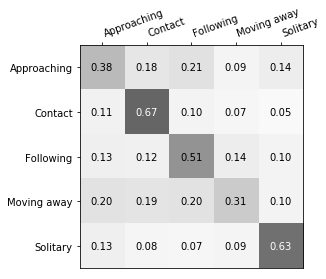

In [178]:
plt.rcParams['figure.facecolor'] = 'w'


cm = confusion_matrix(df['label'], df['pred'])
cm = cm / cm.sum(axis=1, dtype=float, keepdims=True)  # precision

# show matrix
cmimg = plt.matshow(cm, cmap='Greys', vmin=0, vmax=1)

# show labels
ax = plt.gca()
ax.set_xticklabels([''] + label_set.tolist(), rotation=20, ha='left');
ax.set_yticklabels([''] + label_set.tolist(), ha='right');
ax.tick_params(bottom=False)
ax.grid(False)

# print values in cells
hide_threshold=0.005
annot_fmt = '{0:.2f}'
colorvalues = np.mean(cmimg.to_rgba( cm )[:,:,0:3], axis=-1)
you_have_been_warned = False
for i in xrange(cm.shape[0]):
    for j in xrange(cm.shape[1]):
        if cm[i,j] < hide_threshold:
            continue
        ax.annotate(annot_fmt.format(cm[i,j]), xy=(j, i), 
                    horizontalalignment='center', verticalalignment='center', 
                    color= 'k' if colorvalues[i,j] > .5 else 'w')
        
display(get_save_button(ax.figure, os.path.join(local_log_path, 'confusion_matrix.png')))

### Look at probabilities over time

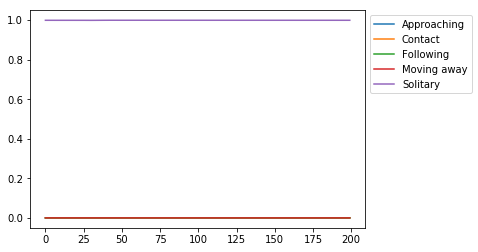

In [177]:
# import seaborn as sns
# sns.set('talk', 'whitegrid')

t0 = 1900
td = 200
plt.plot(range(td), dfprobs.iloc[t0:t0+td, used_labels])
plt.legend(label_set, loc='upper left', bbox_to_anchor=(1,1))

In [31]:
test_videos = sorted(df.index.get_level_values('video').unique())
dfa, le = load_ground_truth_labels(return_label_encoder=True, other_is_contact=True)
dfa = dfa.loc[test_videos, :]


# insert frames between sampled segments
segment_length = 16
dfp = dfprobs.reindex(dfa.index, method='ffill', limit=segment_length-1).dropna()

# smooth probabilities
dfp = dfp.groupby(level='video', group_keys=False).rolling(segment_length, center=True, min_periods=1).mean()

# compute prediction labels from smoothes probabilities
dft = pd.DataFrame(dfp.loc[:, used_labels].idxmax(axis=1), columns=['pred'])
dft =  dft.join(dfa, how='left')


# export button
def export_labels(arg):
    dfexp = dft.copy()
    dfexp['pred'] = le.inverse_transform(dfexp['pred'])
    dfexp['label'] = le.inverse_transform(dfexp['label'])
    mkdir_p(os.path.join(local_log_path, 'predictions'))
    for vid in test_videos:
        dfexp.loc[vid].to_csv(os.path.join(local_log_path, 'predictions', vid + '.csv'), sep=';')
    
btn_export = widgets.Button(description='Export labels')
display(btn_export)
btn_export.on_click(export_labels)

Found 9 annotation files.
Loaded annotations of 9 videos.


In [33]:
dfp.head()

0         1         2         3         4  \
video         frame                                                     
Observation07 1      0.927822  0.020090  0.011314  0.022733  0.017836   
              2      0.911019  0.022352  0.011661  0.028241  0.026483   
              3      0.897578  0.024162  0.011938  0.032647  0.033400   
              4      0.886580  0.025643  0.012165  0.036253  0.039060   
              5      0.877415  0.026877  0.012354  0.039257  0.043776   

                            5  
video         frame            
Observation07 1      0.000206  
              2      0.000244  
              3      0.000274  
              4      0.000299  
              5      0.000320

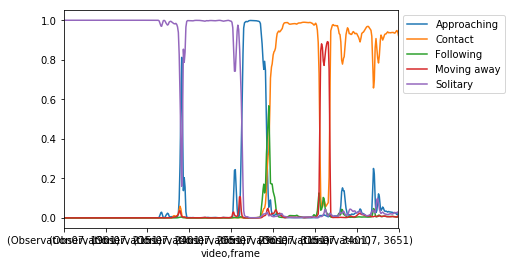

In [16]:
dfp.iloc[t0:t0+td*segment_length].loc[:, used_labels].plot()
plt.legend(label_set, loc='upper left', bbox_to_anchor=(1,1))